# Support Vector Machine (SVM) Classification

In [12]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
data = TrinaryData()
data.df_X.head()

,0,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
T1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


## Data Preparation

## SVM Analysis

In [39]:
lin_clf = svm.LinearSVC()
lin_clf.fit(data.df_X, data.ser_y) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

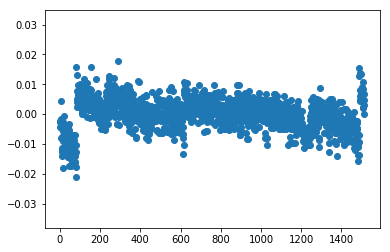

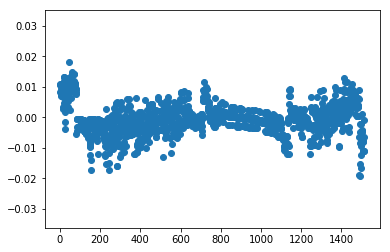

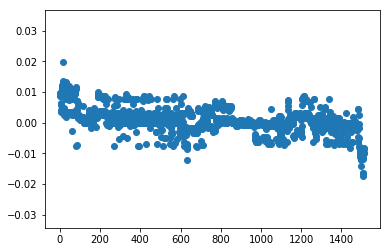

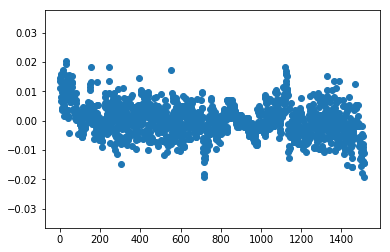

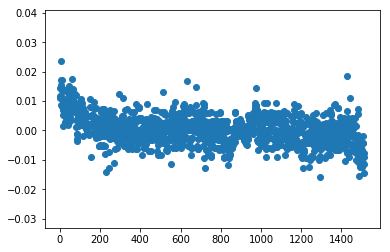

In [47]:
for n in range(5):
    plt.figure()
    plt.scatter(range(1515), lin_clf.coef_[n])

In [22]:
np.random.permutation(data.df_X)

array([[-1, -1, -1, ...,  0,  1,  1],
       [-1, -1, -1, ...,  1,  1,  1],
       [-1, -1, -1, ...,  1,  1,  1],
       ...,
       [-1, -1, -1, ...,  1,  1,  1],
       [-1, -1, -1, ...,  0,  1,  1],
       [-1, -1, -1, ...,  0,  1,  1]])

In [30]:
# Not clear what the score means since have class imbalances
indices = list(data.df_X.index)
scores = []
for _ in range(5):
    indices = np.random.permutation(indices)
    df_X = data.df_X.loc[indices, :]
    ser_y = data.ser_y.loc[indices]
    lin_clf.score(df_X, ser_y)
    scores.append(cross_val_score(lin_clf, df_X, ser_y, cv=3))
print("mean: %f, std: %f" % (np.mean(scores), np.std(scores)))

mean: 0.921693, std: 0.069423


In [32]:
lin_clf.n_support_

AttributeError: 'LinearSVC' object has no attribute 'n_support_'